In [196]:
#pytorch related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split,Dataset
import torchaudio
import torchaudio.transforms as T

In [177]:
#other imports
import pandas as pd
import librosa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [179]:
dataSetPath = '../Datasets/Dataset1/Respiratory_Sound_Database/Respiratory_Sound_Database'


In [180]:
patient_data=pd.read_csv(dataSetPath+ "/patient_diagnosis.csv",names=['pid','disease'])
patient_data.head()



,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


e:\conda\envs\pyt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

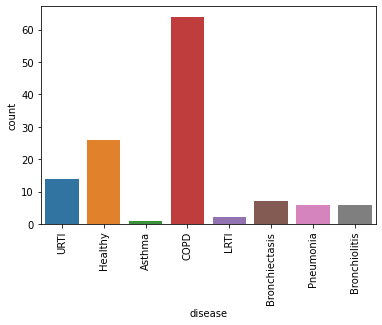

In [181]:
sns.countplot(patient_data.disease)
plt.xticks(rotation=90)

In [182]:
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = ["Asthma","COPD","Bronchiectasis","Pneumonia","URTI","Healthy","Bronchiolitis","LRTI"]
values = array(data)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[4])])

def EncodeOneHot(x):
    return onehot_encoder.transform([label_encoder.transform([x])])

def DecodeOneHot(lst =[]):
    return label_encoder.inverse_transform([argmax(lst)])

In [183]:
EncodeOneHot('Pneumonia')

array([[0., 0., 0., 0., 0., 0., 1., 0.]])

In [184]:
l = [0, 0, 1, 0, 0, 0, 0, 0]
DecodeOneHot(l)

array(['Bronchiolitis'], dtype='<U14')

In [193]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

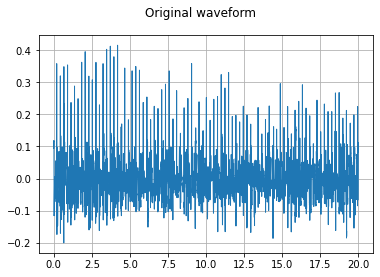

In [194]:
TEST_WAVEFORM, SAMPLE_RATE = torchaudio.load(dataSetPath + '/audio_and_txt_files/'+'101_1b1_Al_sc_Meditron.wav')
plot_waveform(TEST_WAVEFORM, SAMPLE_RATE, title="Original waveform")

In [197]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(TEST_WAVEFORM)

e:\conda\envs\pyt\lib\site-packages\torchaudio\functional\functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


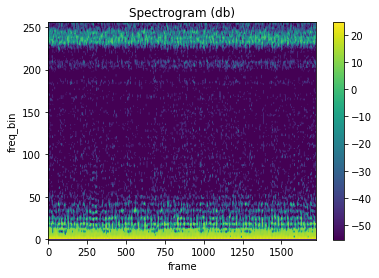

In [198]:
plot_spectrogram(mfcc[0])

In [185]:
class LungSoundDataSet(Dataset):
    def __init__(self,patient_data_labels, data_file_path):
        self.patient_data_labels = patient_data_labels
        self.data_file_path = data_file_path
        self.audioFiles =[]
        for file in os.listdir(data_file_path):
            if file.endswith('.wav'):
                self.audioFiles.append (file)

    def __getitem__(self, index):
        # get correct label
        pid = int(self.audioFiles[index].split('_')[0])             # get pid from file name
        labelPd = patient_data[patient_data['pid'] == pid]          # find correct row
        label = labelPd.iat[0,1]                                    # extract label
        encodedLabel = EncodeOneHot(label)
        return self.audioFiles[index],encodedLabel

   
        
    def __len__(self):
        return len(self.audioFiles)

In [186]:
train_set = LungSoundDataSet(patient_data,dataSetPath + '/audio_and_txt_files')

In [187]:
print(len(train_set))
train_set.__getitem__(0)

920


('101_1b1_Al_sc_Meditron.wav', array([[0., 0., 0., 0., 0., 0., 0., 1.]]))